In [147]:
#pairs trading

In [148]:
import yfinance as yf
import pandas as pd

from itertools import combinations

import numpy as np

import statsmodels
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

import matplotlib.pyplot as plt
from pytickersymbols import PyTickerSymbols
import os

import seaborn as sns



import warnings
warnings.filterwarnings("ignore")


# S&P 500 Pairs Trading Analysis

In this notebook, we perform a quantitative analysis of statistical arbitrage opportunities within the S&P 500 universe. The workflow follows a structured approach:

1. **Data Acquisition:** We retrieve historical price data for all S&P 500 constituents using `yfinance`.
2. **Pre-Filtering by Correlation:** To reduce the number of pairwise combinations, we first filter potential pairs based on their correlation, keeping only those exhibiting sufficient linear relationship.
3. **Cointegration Analysis:** Pairwise cointegration tests are conducted on the filtered universe to identify statistically linked assets suitable for pairs trading.
4. **Trading Strategy Implementation:** A strategy based on the spread and z-score is applied to generate entry and exit signals for selected pairs.
5. **Performance Evaluation:** Results are analyzed for profitability, risk metrics (Sharpe ratio, drawdowns), and inherent limitations of the approach.
6. **Forward Testing / Yearly Validation:** Top cointegrated pairs are evaluated on the subsequent year(s) to assess whether the identified cointegration relationships persist and remain tradable in unseen data.

> *“Statistical arbitrage combines rigorous quantitative analysis with practical trading insights, often revealing opportunities that intuition alone cannot uncover.”*

Let's fetch the daily closing price for the S&P500

In [149]:

use_csv = True #change to false if you want new data each run
filename = "SP500_prices.csv"


if use_csv and os.path.exists(filename):
    print(f"{filename} already exists --> using file")
    df = pd.read_csv(filename, index_col=0, parse_dates=True)
else:
    print(f"{filename} does not exist --> downloading from Yahoo Finance")

    # fetching tickers list S&P 500
    stock_data = PyTickerSymbols()
    SP500 = stock_data.get_stocks_by_index('S&P 500')
    TICKERS = [TICK['symbol'] for TICK in SP500]

    # Downloading closing datas
    df = yf.download(TICKERS, start="2023-01-01", end="2023-09-30")['Close']

    # Download to csv to reuse
    df.to_csv(filename, index=True)
    print(f"Saved to {filename}")

df.head()


SP500_prices.csv already exists --> using file


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACGL,ACN,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-03,147.012177,12.74,143.220459,123.330643,146.532639,NaN,NaN,103.829872,59.393120,258.138885,...,83.384613,63.671192,96.910606,30.346582,107.169701,120.430840,124.327248,260.200012,43.424728,142.700821
2023-01-04,148.609283,13.59,143.551270,124.602699,147.714798,NaN,NaN,105.374344,59.687901,257.260162,...,88.537102,64.216400,97.192657,31.358444,107.005203,122.062378,125.479897,262.989990,45.010807,144.751190
2023-01-05,149.040421,13.99,144.751541,123.281326,147.534302,NaN,NaN,104.985863,59.849552,251.185425,...,88.965668,62.916973,99.367241,30.717913,103.967003,121.132782,123.155098,260.059998,44.222244,141.340332
2023-01-06,144.690018,14.18,145.564331,127.817383,150.295654,NaN,NaN,106.435555,60.762417,257.135956,...,91.137711,64.779778,100.568283,31.033537,107.663170,123.589600,122.783897,273.420013,45.933784,143.468460
2023-01-09,144.494034,14.61,143.900955,128.340012,145.882889,NaN,NaN,106.265015,59.592808,261.472412,...,91.877937,65.406769,98.693954,30.625076,108.166328,123.086838,123.125778,279.290009,45.718719,142.904861


### 1.2 Correlation & Cointegration

To identify potentially tradable pairs, we first compute correlations to reduce the number of combinations, followed by a cointegration test.

The total number of possible pairs is given by the combination formula:

$ \text{Number of pairs} = \binom{N}{2} = \frac{N!}{2!(N-2)!} $

For our universe of 498 tickers, this results in:

$ \binom{498}{2} = \frac{498 \cdot 497}{2} $

Filtering by correlation before cointegration helps reduce computational complexity and removes obviously uncorrelated pairs.


In [150]:
498*497/2

123753.0

In [151]:
"""
For practical implementation, we generate all possible stock pairs using Python's `itertools.combinations`.
This approach efficiently enumerates all unique pairs without repetition.
"""

df_combination = pd.DataFrame(combinations(df.columns, 2), columns=['Stock1','Stock2'])
df_combination.head()

,Stock1,Stock2
0,A,AAL
1,A,AAP
2,A,AAPL
3,A,ABBV
4,A,ABC


Now we can filter by correlation

In [152]:

# Compute correlation for each pair
def pair_corr(row):
    s1 = df[row['Stock1']]
    s2 = df[row['Stock2']]
    return np.corrcoef(s1, s2)[0,1]

df_combination['correlation'] = df_combination.apply(pair_corr, axis=1)
df_combination.head()

,Stock1,Stock2,correlation
0,A,AAL,0.129968
1,A,AAP,0.921043
2,A,AAPL,-0.839707
3,A,ABBV,0.352612
4,A,ABC,NaN


Filter for highly correlated pairs (e.g., correlation > 0.95)

In [153]:
correl_coef = 0.95


df_combination = df_combination[df_combination.correlation > correl_coef]
df_combination.head()

,Stock1,Stock2,correlation
233,A,INCY,0.962241
471,A,WAT,0.952759
1595,AAPL,CPRT,0.959298
1598,AAPL,CRM,0.957978
1799,AAPL,MSFT,0.971048


# 1.3 Linear Regression & Residuals
To construct a pairs trading strategy, we need to model the relationship between two stocks using a linear regression. This allows us to compute the spread (residuals), which will later drive our trading signals.
For each candidate pair $(X, Y)$:

$Y_t = \alpha + \beta X_t + \varepsilon_t$

* $\alpha$ : intercept of the regression
* $\beta$ : slope coefficient
* $\varepsilon_t$ : residuals (spread)
* **$p\_value$ : significance of the cointegration relationship (from the Augmented Dickey-Fuller test on residuals)**

We use Ordinary Least Squares (OLS) for its simplicity and interpretability, providing a straightforward estimation of $\alpha$ and $\beta$.

Once the regression is fitted, the residuals (spread) are calculated as:

$\text{spread}_t = Y_t - (\alpha + \beta X_t)$

The spread can then be standardized into a z-score:

$z_t = \frac{\text{spread}_t - \overline{\text{spread}}}{\sigma_{\text{spread}}}$

This z-score is used to generate entry and exit signals in the pairs trading strategy.


In [154]:

def do_reg(stock1, stock2):
  """
  The function do_reg(stock1, stock2) performs a simple linear regression between two stock price series and then tests whether the residuals are stationary:
  """
  X = df[stock1].values
  y = df[stock2].values

  X = sm.add_constant(X)
  model = sm.OLS(y, X).fit()
  alpha,beta = model.params

  residuals = y - (alpha + beta * X[:,1])

  if np.isnan(residuals).any():
    return np.nan
  adf_results = adfuller(residuals)

  return adf_results[0], adf_results[1], beta, alpha



In [155]:
min_coint = 0.005 #adjust to your liking

df_combination[['adf_stat', 'p_value', 'beta', 'alpha']] = df_combination.apply(lambda row:pd.Series(do_reg(row['Stock1'], row['Stock2'])), axis=1)
df_combination[df_combination.p_value < min_coint].sort_values(by='adf_stat')

,Stock1,Stock2,correlation,adf_stat,p_value,beta,alpha
111166,NWL,WAT,0.951572,-5.834705,3.901012e-07,12.390244,165.171695
67267,EQIX,MCO,0.959278,-5.679525,8.549891e-07,0.514185,-46.849963
14060,AMCR,CCI,0.967084,-5.529020,1.805179e-06,18.409678,-68.400658
110307,NTAP,STZ,0.951966,-5.001585,2.203342e-05,2.703861,49.530119
41437,CHD,RSG,0.968993,-4.982312,2.405335e-05,1.567246,-2.898900
...,...,...,...,...,...,...,...
79460,GL,USB,0.952482,-3.663063,4.663747e-03,0.978677,-74.126183
104529,MLM,RCL,0.967955,-3.661238,4.692615e-03,0.365385,-62.209069
32787,BRK-B,WMT,0.954391,-3.657887,4.746054e-03,0.122527,8.547287
44214,CMA,PFG,0.951742,-3.656615,4.766489e-03,0.572545,46.203626


# 1.4 Pre-Backtest Analysis: Spread & Z-Score

In this section, we prepare the groundwork for our practical pairs trading backtest.
Instead of a case study per se, we focus on illustrating the spread calculation and z-score standardization for one of the most promising cointegrated pairs.

We compute the spread as the residual from the linear regression and then standardize it into a z-score::
* $\text{spread}_t = Y_t - (\alpha + \beta X_t)$,

* $z_t = \frac{\text{spread}_t - \overline{\text{spread}}}{\sigma_{\text{spread}}}$

This allows us to visualize mean-reversion opportunities and potential trading signals.
> The pair is selected using a p-value range (e.g., $0.005 < p < 0.06$) to reduce noise from extremely low p-values, which can generate noisy signals and hurt the Sharpe ratio in backtests.


Found 73 cointegrated pairs with p-value between 0.005 and 0.06
Selected pair: PHM vs PWR
Alpha: 57.8190, Beta: 1.7877
ADF Statistic: -3.6232, p-value: 0.0053
Spread - Mean: 0.0000, Std: 5.2725


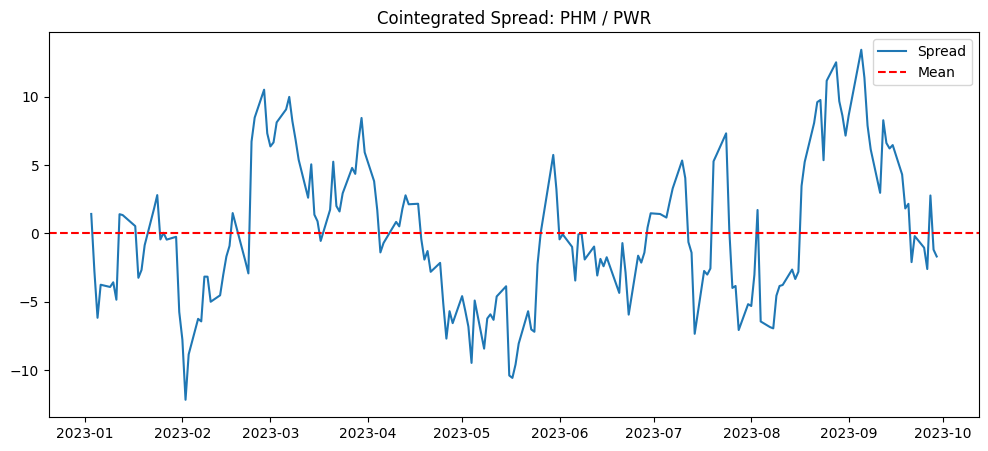

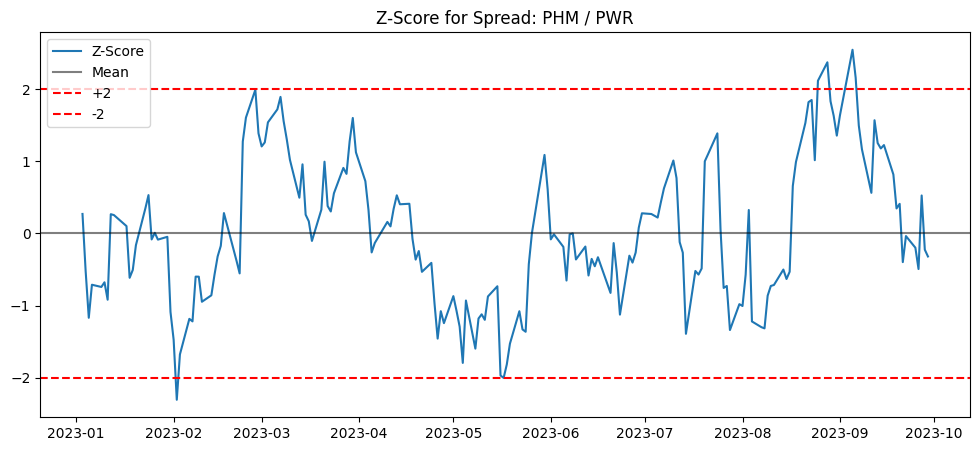

In [156]:
# Dynamic parameters
p_min = 0.005
p_max = 0.06
top_n_index = 7      # index to pick a pair (0 = the most cointegrated)


# filter paris by their bounds of p-val and sort by ADF stats
cointegrated_pairs = df_combination[
    (df_combination.p_value >= p_min) &
    (df_combination.p_value <= p_max)
].sort_values(by='adf_stat')

print(f"Found {len(cointegrated_pairs)} cointegrated pairs with p-value between {p_min} and {p_max}")

# Pair selec by top index
if len(cointegrated_pairs) > top_n_index:
    best_pair = cointegrated_pairs.iloc[top_n_index]
    stock1, stock2 = best_pair['Stock1'], best_pair['Stock2']
    alpha, beta = best_pair['alpha'], best_pair['beta']

    print(f"Selected pair: {stock1} vs {stock2}")
    print(f"Alpha: {alpha:.4f}, Beta: {beta:.4f}")
    print(f"ADF Statistic: {best_pair['adf_stat']:.4f}, p-value: {best_pair['p_value']:.4f}")

    # Compute spread & zscore
    spread = df[stock2] - (alpha + beta * df[stock1])
    spread_mean = spread.mean()
    spread_std = spread.std()
    z_score = (spread - spread_mean) / spread_std

    print(f"Spread - Mean: {spread_mean:.4f}, Std: {spread_std:.4f}")

    # spread viz
    plt.figure(figsize=(12,5))
    plt.plot(spread, label='Spread')
    plt.axhline(spread_mean, color='red', linestyle='--', label='Mean')
    plt.legend()
    plt.title(f'Cointegrated Spread: {stock1} / {stock2}')
    plt.show()

    # zscore viz
    plt.figure(figsize=(12,5))
    plt.plot(z_score, label='Z-Score')
    plt.axhline(0, color='black', linestyle='-', alpha=0.5, label='Mean')
    plt.axhline(2, color='red', linestyle='--', label='+2')
    plt.axhline(-2, color='red', linestyle='--', label='-2')
    plt.legend()
    plt.title(f'Z-Score for Spread: {stock1} / {stock2}')
    plt.show()

else:
    print("No cointegrated pairs found in the specified p-value range!")


# 2. Backtesting

In this section, we implement a practical backtest for our pairs trading strategy.
The goal is to evaluate the performance of a cointegrated pair over the full historical period, using the standardized spread (z-score) to generate entry and exit signals.

Key points:


* Entry and exit rules based on z-score:
  * Go **LONG** when the spread is significantly negative (z-score < -2)
  * Go **SHORT** when the spread is significantly positive (z-score > 2)
  * **Exit** positions when the spread reverts to the mean (z-score ≈ 0)
* Risk management:
  * Stop-loss at ±3 to limit extreme losses
  * Maximum holding period: 60 days
  * Capital allocation to maintain a dollar-neutral spread
* Performance metrics:
  * Total return and PnL
  * Annualized Sharpe ratio
  * Maximum drawdown
  * Number of trades and win rate
  * Average z-score reversion per trade



This setup allows us to test our mean-reversion hypothesis on the selected pair and visualize the trading signals.
All decisions are based purely on spread statistics, and the backtest here is illustrative rather than optimized—it is not the main focus of this notebook, so performance should not be interpreted as “production-ready.”

The entry/exit thresholds use a z-score of ±2. This choice aligns with the properties of a standard normal distribution, capturing approximately 95% of expected fluctuations. These thresholds can be adjusted depending on the desired sensitivity.




RUNNING PRACTICAL PAIRS TRADING BACKTEST

Trading PHM/PWR from 2023-01-03 to 2023-09-29
Z-score opportunities: 4 above, 2 below
📈 ENTER LONG: 2023-02-02, z=-2.31
🔄 EXIT LONG_SPREAD: 2023-02-17, z=0.28, PnL=$-308.00 (-3.08%), Reason: Mean reversion
📈 ENTER LONG: 2023-05-17, z=-2.00
🔄 EXIT LONG_SPREAD: 2023-05-26, z=0.01, PnL=$-106.52 (-1.10%), Reason: Mean reversion
📉 ENTER SHORT: 2023-08-25, z=2.12
🔄 EXIT SHORT_SPREAD: 2023-09-21, z=-0.40, PnL=$-490.75 (-5.12%), Reason: Mean reversion

PRACTICAL BACKTEST RESULTS
Trading Pair: PHM / PWR
Period: 2023-01-03 to 2023-09-29
Initial Capital: $10,000.00
Final Capital: $9,094.73
Total Return: -9.05%
Total PnL: $-905.27
Sharpe Ratio: -1.78
Max Drawdown: -9.05%
Total Trades: 3
Win Rate: 0.0%
Average Trade Return: -3.10%
Dates length: 188, Portfolio values length: 188


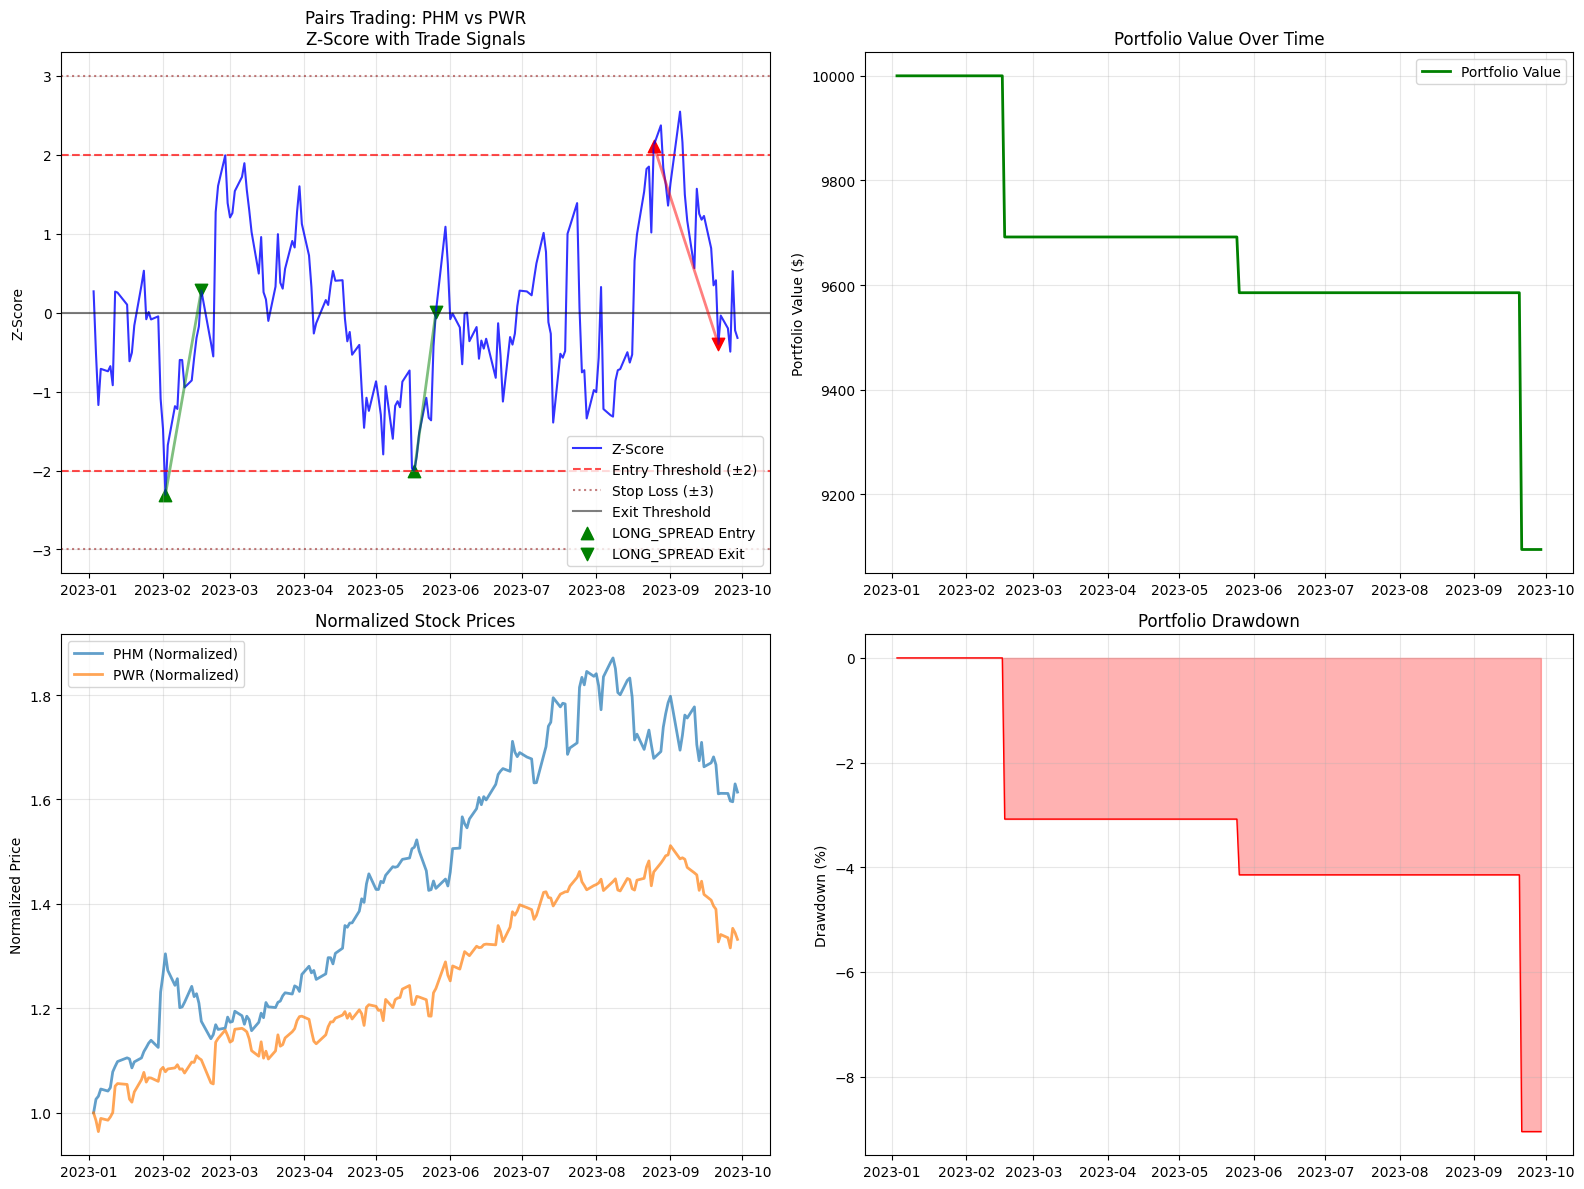


DETAILED TRADE ANALYSIS:
🔴 Trade 1: LONG_SPREAD  | Entry: 2023-02-02 (z=-2.31) | Exit: 2023-02-17 (z= 0.28) | Held: 15 days | PnL: $-308.00 ( -3.08%) | Reason: Mean reversion
🔴 Trade 2: LONG_SPREAD  | Entry: 2023-05-17 (z=-2.00) | Exit: 2023-05-26 (z= 0.01) | Held:  9 days | PnL: $-106.52 ( -1.10%) | Reason: Mean reversion
🔴 Trade 3: SHORT_SPREAD | Entry: 2023-08-25 (z= 2.12) | Exit: 2023-09-21 (z=-0.40) | Held: 27 days | PnL: $-490.75 ( -5.12%) | Reason: Mean reversion

STRATEGY ANALYSIS:
• Z-score exceeded ±2.0 on 6 days
• Maximum z-score: 2.55, Minimum z-score: -2.31
• Z-score volatility (std): 1.00
• Average holding period: 17.0 days
• Average z-score reversion per trade: 2.37


In [158]:

#Backtest - Fixed version
class PracticalPairsTradingBacktest:
    def __init__(self, initial_capital=10000):
        self.initial_capital = initial_capital
        self.capital = initial_capital
        self.trades = []
        self.portfolio_value = []
        self.dates = []

    def run_backtest(self, df, stock1, stock2, z_score,
                   entry_threshold=2, exit_threshold=0,
                   stop_loss=3, max_hold_days=60):
        """
        Using full-period cointegration and focus on z-score behavior
        """
        capital = self.initial_capital
        position = 0  # 0: no position, 1: long spread, -1: short spread
        portfolio_value = [capital]
        dates = [df.index[0]]  # Start with first date
        trades = []
        entry_date = None

        print(f"\nTrading {stock1}/{stock2} from {df.index[0].strftime('%Y-%m-%d')} to {df.index[-1].strftime('%Y-%m-%d')}")
        print(f"Z-score opportunities: {(z_score > entry_threshold).sum()} above, {(z_score < -entry_threshold).sum()} below")

        for i in range(len(df)):
            current_date = df.index[i]
            current_z = z_score.iloc[i]
            price1, price2 = df[stock1].iloc[i], df[stock2].iloc[i]

            # TRADING LOGIC
            if position == 0:  # No current position
                # ENTRY SIGNALS
                if current_z > entry_threshold:  # Spread too wide - SHORT spread
                    shares1, shares2 = self._calculate_position_size(price1, price2, capital)
                    if shares1 > 0 and shares2 > 0:
                        position = -1
                        entry_date = current_date
                        trade = {
                            'entry_date': current_date,
                            'action': 'SHORT_SPREAD',
                            'stock1_shares': shares1,      # Long stock1
                            'stock2_shares': -shares2,     # Short stock2
                            'entry_z': current_z,
                            'entry_price1': price1,
                            'entry_price2': price2,
                            'entry_value': capital
                        }
                        trades.append(trade)
                        print(f"📉 ENTER SHORT: {current_date.strftime('%Y-%m-%d')}, z={current_z:.2f}")

                elif current_z < -entry_threshold:  # Spread too narrow - LONG spread
                    shares1, shares2 = self._calculate_position_size(price1, price2, capital)
                    if shares1 > 0 and shares2 > 0:
                        position = 1
                        entry_date = current_date
                        trade = {
                            'entry_date': current_date,
                            'action': 'LONG_SPREAD',
                            'stock1_shares': -shares1,     # Short stock1
                            'stock2_shares': shares2,      # Long stock2
                            'entry_z': current_z,
                            'entry_price1': price1,
                            'entry_price2': price2,
                            'entry_value': capital
                        }
                        trades.append(trade)
                        print(f"📈 ENTER LONG: {current_date.strftime('%Y-%m-%d')}, z={current_z:.2f}")

            elif position != 0:  # Have a position - check for exit
                current_trade = trades[-1]
                days_held = (current_date - entry_date).days

                # EXIT CONDITIONS
                exit_signal = False
                exit_reason = ""

                # 1. Normal reversion to mean
                if (position == -1 and current_z < exit_threshold) or \
                   (position == 1 and current_z > exit_threshold):
                    exit_signal = True
                    exit_reason = "Mean reversion"

                # 2. Stop loss - spread moves against us
                elif (position == -1 and current_z > stop_loss) or \
                     (position == 1 and current_z < -stop_loss):
                    exit_signal = True
                    exit_reason = "Stop loss"

                # 3. Maximum holding period
                elif days_held >= max_hold_days:
                    exit_signal = True
                    exit_reason = "Time limit"

                if exit_signal:
                    # Calculate PnL
                    if position == -1:  # Short spread exit
                        pnl_stock1 = current_trade['stock1_shares'] * (price1 - current_trade['entry_price1'])
                        pnl_stock2 = current_trade['stock2_shares'] * (current_trade['entry_price2'] - price2)
                    else:  # Long spread exit
                        pnl_stock1 = current_trade['stock1_shares'] * (current_trade['entry_price1'] - price1)
                        pnl_stock2 = current_trade['stock2_shares'] * (price2 - current_trade['entry_price2'])

                    trade_pnl = pnl_stock1 + pnl_stock2
                    capital += trade_pnl

                    # Update trade record
                    current_trade['exit_date'] = current_date
                    current_trade['exit_z'] = current_z
                    current_trade['exit_value'] = capital
                    current_trade['pnl'] = trade_pnl
                    current_trade['pnl_pct'] = (trade_pnl / current_trade['entry_value']) * 100
                    current_trade['exit_reason'] = exit_reason
                    current_trade['days_held'] = days_held

                    print(f"🔄 EXIT {current_trade['action']}: {current_date.strftime('%Y-%m-%d')}, "
                          f"z={current_z:.2f}, PnL=${trade_pnl:+.2f} ({current_trade['pnl_pct']:+.2f}%), "
                          f"Reason: {exit_reason}")

                    position = 0
                    entry_date = None

            # Update portfolio value and dates for EVERY day
            portfolio_value.append(capital)
            dates.append(current_date)

        self.portfolio_value = portfolio_value
        self.dates = dates
        self.trades = trades
        self.final_capital = capital
        return trades, portfolio_value

    def _calculate_position_size(self, price1, price2, capital, risk_per_trade=0.8):
        """Calculate position sizes for dollar-neutral spread"""
        trade_capital = capital * risk_per_trade

        # Simple equal dollar allocation
        shares1 = int(trade_capital / 2 / price1)
        shares2 = int(trade_capital / 2 / price2)

        # Ensure minimum shares
        if shares1 < 1: shares1 = 1
        if shares2 < 1: shares2 = 1

        return shares1, shares2

    def get_performance_metrics(self):
        """Calculate comprehensive performance metrics"""
        if not self.portfolio_value:
            return {}

        returns = pd.Series(self.portfolio_value).pct_change().dropna()

        total_return = (self.final_capital - self.initial_capital) / self.initial_capital * 100
        sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252) if returns.std() > 0 else 0

        # Calculate max drawdown
        portfolio_series = pd.Series(self.portfolio_value)
        rolling_max = portfolio_series.expanding().max()
        drawdowns = (portfolio_series - rolling_max) / rolling_max * 100
        max_drawdown = drawdowns.min()

        # Trade metrics
        if self.trades:
            completed_trades = [t for t in self.trades if 'pnl' in t]
            if completed_trades:
                winning_trades = [t for t in completed_trades if t['pnl'] > 0]
                win_rate = len(winning_trades) / len(completed_trades) * 100
                avg_trade_return = np.mean([t['pnl_pct'] for t in completed_trades])
                total_trades = len(completed_trades)
            else:
                win_rate = avg_trade_return = total_trades = 0
        else:
            win_rate = avg_trade_return = total_trades = 0

        return {
            'initial_capital': self.initial_capital,
            'final_capital': self.final_capital,
            'total_return_pct': total_return,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown_pct': max_drawdown,
            'total_trades': total_trades,
            'win_rate_pct': win_rate,
            'avg_trade_return_pct': avg_trade_return,
            'total_pnl': self.final_capital - self.initial_capital
        }

# Run the practical backtest
print("RUNNING PRACTICAL PAIRS TRADING BACKTEST")
print("="*60)

backtest = PracticalPairsTradingBacktest(initial_capital=10000)
trades, portfolio_values = backtest.run_backtest(df, stock1, stock2, z_score,
                                               entry_threshold=2.0,
                                               exit_threshold=0.0,
                                               stop_loss=3.0,
                                               max_hold_days=60)

# Calculate performance metrics
metrics = backtest.get_performance_metrics()

# Print results
print("\n" + "="*50)
print("PRACTICAL BACKTEST RESULTS")
print("="*50)
print(f"Trading Pair: {stock1} / {stock2}")
print(f"Period: {df.index[0].strftime('%Y-%m-%d')} to {df.index[-1].strftime('%Y-%m-%d')}")
print(f"Initial Capital: ${metrics['initial_capital']:,.2f}")
print(f"Final Capital: ${metrics['final_capital']:,.2f}")
print(f"Total Return: {metrics['total_return_pct']:.2f}%")
print(f"Total PnL: ${metrics['total_pnl']:+.2f}")
print(f"Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")
print(f"Max Drawdown: {metrics['max_drawdown_pct']:.2f}%")
print(f"Total Trades: {metrics['total_trades']}")
print(f"Win Rate: {metrics['win_rate_pct']:.1f}%")
print(f"Average Trade Return: {metrics['avg_trade_return_pct']:.2f}%")

# Enhanced Visualization - FIXED SYNCHRONIZATION
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Z-score with trade signals
ax1.plot(df.index, z_score, label='Z-Score', linewidth=1.5, color='blue', alpha=0.8)
ax1.axhline(y=2, color='red', linestyle='--', alpha=0.7, label='Entry Threshold (±2)')
ax1.axhline(y=-2, color='red', linestyle='--', alpha=0.7)
ax1.axhline(y=3, color='darkred', linestyle=':', alpha=0.5, label='Stop Loss (±3)')
ax1.axhline(y=-3, color='darkred', linestyle=':', alpha=0.5)
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.5, label='Exit Threshold')

# Mark trades
colors = {'SHORT_SPREAD': 'red', 'LONG_SPREAD': 'green'}
for trade in trades:
    if 'exit_date' in trade:
        # Entry point
        ax1.scatter(trade['entry_date'], trade['entry_z'],
                   color=colors[trade['action']], s=80, marker='^',
                   label=f"{trade['action']} Entry" if trade == trades[0] else "")
        # Exit point
        ax1.scatter(trade['exit_date'], trade['exit_z'],
                   color=colors[trade['action']], s=80, marker='v',
                   label=f"{trade['action']} Exit" if trade == trades[0] else "")
        # Trade line
        ax1.plot([trade['entry_date'], trade['exit_date']],
                [trade['entry_z'], trade['exit_z']],
                color=colors[trade['action']], alpha=0.5, linewidth=2)

ax1.set_ylabel('Z-Score')
ax1.set_title(f'Pairs Trading: {stock1} vs {stock2}\nZ-Score with Trade Signals')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Portfolio value - NOW SYNCHRONIZED
print(f"Dates length: {len(backtest.dates)}, Portfolio values length: {len(portfolio_values)}")
ax2.plot(backtest.dates, portfolio_values, label='Portfolio Value',
         linewidth=2, color='green')
ax2.set_ylabel('Portfolio Value ($)')
ax2.set_title('Portfolio Value Over Time')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Individual stock prices (normalized)
norm_price1 = df[stock1] / df[stock1].iloc[0]
norm_price2 = df[stock2] / df[stock2].iloc[0]
ax3.plot(df.index, norm_price1, label=f'{stock1} (Normalized)', alpha=0.7, linewidth=2)
ax3.plot(df.index, norm_price2, label=f'{stock2} (Normalized)', alpha=0.7, linewidth=2)
ax3.set_ylabel('Normalized Price')
ax3.set_title('Normalized Stock Prices')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Drawdown - NOW SYNCHRONIZED
portfolio_series = pd.Series(portfolio_values)
rolling_max = portfolio_series.expanding().max()
drawdown = (portfolio_series - rolling_max) / rolling_max * 100
ax4.fill_between(backtest.dates, drawdown, 0, alpha=0.3, color='red')
ax4.plot(backtest.dates, drawdown, color='red', linewidth=1)
ax4.set_ylabel('Drawdown (%)')
ax4.set_title('Portfolio Drawdown')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed trade analysis
if trades:
    print("\nDETAILED TRADE ANALYSIS:")
    print("="*100)
    for i, trade in enumerate(trades, 1):
        if 'exit_date' in trade:
            pnl_color = "🟢" if trade['pnl'] > 0 else "🔴"
            print(f"{pnl_color} Trade {i}: {trade['action']:12} | "
                  f"Entry: {trade['entry_date'].strftime('%Y-%m-%d')} (z={trade['entry_z']:5.2f}) | "
                  f"Exit: {trade['exit_date'].strftime('%Y-%m-%d')} (z={trade['exit_z']:5.2f}) | "
                  f"Held: {trade['days_held']:2} days | "
                  f"PnL: ${trade['pnl']:7.2f} ({trade['pnl_pct']:6.2f}%) | "
                  f"Reason: {trade['exit_reason']}")

# Additional analysis
print(f"\nSTRATEGY ANALYSIS:")
print(f"• Z-score exceeded ±2.0 on {((z_score > 2) | (z_score < -2)).sum()} days")
print(f"• Maximum z-score: {z_score.max():.2f}, Minimum z-score: {z_score.min():.2f}")
print(f"• Z-score volatility (std): {z_score.std():.2f}")

if trades:
    avg_hold_time = np.mean([t['days_held'] for t in trades if 'days_held' in t])
    print(f"• Average holding period: {avg_hold_time:.1f} days")

    # Check if we're capturing the mean reversion
    z_reversion = []
    for trade in trades:
        if 'exit_z' in trade:
            z_move = abs(trade['entry_z'] - trade['exit_z'])
            z_reversion.append(z_move)

    print(f"• Average z-score reversion per trade: {np.mean(z_reversion):.2f}")
else:
    print("\n❌ No trades were executed. Possible reasons:")
    print("   - Z-score never exceeded entry thresholds with sufficient capital")
    print("   - Position sizing requirements not met")
    print("   - Check if prices contain NaN values")

    # Debug info
    print(f"\nDEBUG INFO:")
    print(f"  Stock1 ({stock1}) price range: ${df[stock1].min():.2f} - ${df[stock1].max():.2f}")
    print(f"  Stock2 ({stock2}) price range: ${df[stock2].min():.2f} - ${df[stock2].max():.2f}")
    print(f"  Available capital: ${backtest.capital:.2f}")
    print(f"  Z-score extremes: {z_score.min():.2f} to {z_score.max():.2f}")

# 2.2 Backtesting all the pairs
Now we will backtest the full list of pairs in order to run some analysis on our global strategy

In [159]:
# CSV to reuse datas if we need to compare different strategy
results_csv = "pairs_backtest_results.csv"

all_metrics_df = pd.DataFrame()
nrows = len(cointegrated_pairs)



for i in range(nrows):
    best_pair = cointegrated_pairs.iloc[i]
    stock1, stock2 = best_pair['Stock1'], best_pair['Stock2']

    # Zscore compute
    res = sm.OLS(df[stock1], sm.add_constant(df[stock2])).fit()
    beta = res.params[1]
    spread = df[stock1] - beta * df[stock2]
    z_score = (spread - spread.mean()) / spread.std()

    # Backtest
    backtest = PracticalPairsTradingBacktest(initial_capital=10000)
    trades, portfolio_values = backtest.run_backtest(
        df, stock1, stock2, z_score,
        entry_threshold=2.0,
        exit_threshold=0.0,
        stop_loss=3.0,
        max_hold_days=60
    )

    # Metrics
    metrics = backtest.get_performance_metrics()
    metrics['Stock1'] = stock1
    metrics['Stock2'] = stock2
    metrics['correlation'] = best_pair['correlation']

    # get pvalue from df_combination
    pval_row = df_combination[
        (df_combination['Stock1'] == stock1) &
        (df_combination['Stock2'] == stock2)
    ]

    if not pval_row.empty:
        metrics['p_value'] = pval_row['p_value'].values[0]
    else:
        metrics['p_value'] = np.nan

    # Append to DataFrame
    all_metrics_df = pd.concat([all_metrics_df, pd.DataFrame([metrics])], ignore_index=True)

    # Append to CSV or create it
    if not os.path.exists(results_csv):
        all_metrics_df.to_csv(results_csv, index=False)
    else:
        pd.DataFrame([metrics]).to_csv(results_csv, mode='a', header=False, index=False)

    # Print quick summary
    print(f"\n=== {stock1}/{stock2} ===")
    print(f"Corr: {best_pair['correlation']:.3f}, P-value: {metrics['p_value']:.4f}, Total PnL: ${metrics['total_pnl']:+.2f}, Sharpe: {metrics['sharpe_ratio']:.2f}, Trades: {metrics['total_trades']}")

print("\n✅ Backtest completed for all pairs")
all_metrics_df = all_metrics_df.dropna()



Trading PHM/PWR from 2023-01-03 to 2023-09-29
Z-score opportunities: 1 above, 4 below
📉 ENTER SHORT: 2023-02-02, z=2.07
🔄 EXIT SHORT_SPREAD: 2023-02-16, z=-0.09, PnL=$-191.57 (-1.92%), Reason: Mean reversion
📈 ENTER LONG: 2023-02-27, z=-2.23
🔄 EXIT LONG_SPREAD: 2023-04-05, z=0.06, PnL=$+297.67 (+3.03%), Reason: Mean reversion
📈 ENTER LONG: 2023-08-28, z=-2.06
🔄 EXIT LONG_SPREAD: 2023-09-21, z=0.54, PnL=$-591.96 (-5.86%), Reason: Mean reversion

=== PHM/PWR ===
Corr: 0.967, P-value: 0.0053, Total PnL: $-485.86, Sharpe: -0.80, Trades: 3

Trading AVGO/LRCX from 2023-01-03 to 2023-09-29
Z-score opportunities: 5 above, 3 below
📈 ENTER LONG: 2023-02-02, z=-2.06
🔄 EXIT LONG_SPREAD: 2023-03-03, z=0.66, PnL=$-188.56 (-1.89%), Reason: Mean reversion
📈 ENTER LONG: 2023-05-17, z=-2.00
🔄 EXIT LONG_SPREAD: 2023-05-31, z=0.25, PnL=$+1176.16 (+11.99%), Reason: Mean reversion
📉 ENTER SHORT: 2023-06-15, z=2.01
🔄 EXIT SHORT_SPREAD: 2023-07-27, z=-0.91, PnL=$+642.52 (+5.85%), Reason: Mean reversion

=== 

In [161]:
print(str(len(all_metrics_df[all_metrics_df['total_pnl'] > 1])) + " Postive PNL trade on", len(all_metrics_df), "traded pair")
all_metrics_df.head()

44 Postive PNL trade on 73 traded pair


,initial_capital,final_capital,total_return_pct,sharpe_ratio,max_drawdown_pct,total_trades,win_rate_pct,avg_trade_return_pct,total_pnl,Stock1,Stock2,correlation,p_value
0,10000,9514.137184,-4.858628,-0.799591,-5.857480,3,33.333333,-1.579447,-485.862816,PHM,PWR,0.967376,0.005333
1,10000,11630.119705,16.301197,1.375998,-1.885632,3,66.666667,5.316574,1630.119705,AVGO,LRCX,0.955979,0.005407
2,10000,10643.087082,6.430871,0.977558,-1.132675,2,50.000000,3.258761,643.087082,BK,USB,0.950216,0.005842
3,10000,10413.679901,4.136799,1.818778,0.000000,3,100.000000,1.362460,413.679901,CHD,TYL,0.956408,0.005946
4,10000,11747.252216,17.472522,1.942915,0.000000,3,100.000000,5.526307,1747.252216,MAR,PNR,0.953333,0.005979
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,10000,10433.455151,4.334552,1.160859,0.000000,1,100.000000,4.334552,433.455151,CPRT,GE,0.956510,0.049385
69,10000,10961.499878,9.614999,1.507353,-0.789895,3,66.666667,3.145616,961.499878,AME,MLM,0.950613,0.049986
70,10000,15483.827644,54.838276,1.627910,0.000000,2,100.000000,24.487685,5483.827644,AVGO,NVDA,0.977235,0.051003
71,10000,9809.035962,-1.909640,-1.160859,-1.909640,1,0.000000,-1.909640,-190.964038,RF,USB,0.978226,0.051701


# 2.3 deeper analysis
In this section, we analyze the backtest results across all cointegrated pairs.
The goal is to get a high-level view of how the strategy performs on a portfolio of pairs
rather than a single pair. We focus on both profitability and risk metrics, including PnL and Sharpe ratio.


- The cumulative PnL represents the total profit or loss generated if we had traded all selected pairs simultaneously.
- The mean Sharpe ratio indicates how consistent returns are relative to volatility.
- Individual pair performance may vary considerably; some pairs dominate PnL while others contribute little or negative results.
- By visualizing the distribution of PnL and Sharpe ratios, we can identify outlier pairs that may be removed or further investigated.

In [162]:
# cumulative pnl
cumulative_pnl = all_metrics_df['total_pnl'].sum()

# mean sharpe
mean_sharpe = all_metrics_df['sharpe_ratio'].mean()

# global result
print(f"\n=== Global strategy assessement ===")
print(f"Tot. cumulative PNL : ${cumulative_pnl:+.2f}")
print(f"Mean sharpe : {mean_sharpe:.2f}")

# strategy eval
if cumulative_pnl > 0:
    pnl_msg = f"-> Current strategy is globally winning on the {len(all_metrics_df)} pairs"
else:
    pnl_msg = f"-> Current strategy is globally losing on the {len(all_metrics_df)} pairs"

#Sharpe
if mean_sharpe < 0.5:
    risk_msg = "⚠ Strategy is too risky on average (Sharpe < 0.5)"
elif mean_sharpe < 1:
    risk_msg = "Strategy is moderate in risk (Sharpe between 0.5 and 1)"
else:
    risk_msg = "✅ Strategy looks solid (Sharpe ≥ 1)"

print(pnl_msg)
print(risk_msg)



=== Résultat global ===
Tot. cumulative PNL : $+22465.08
Mean sharpe : 0.25
-> Current strategy is globally winning on the 73 pairs
⚠ Strategy is too risky on average (Sharpe < 0.5)


In [171]:
# Find BAC vs RF in cointegrated_pairs
row_index = cointegrated_pairs[
    (cointegrated_pairs['Stock1'] == 'BAC') &
    (cointegrated_pairs['Stock2'] == 'RF')
].index[0]

print(f"BAC vs RF is at index: {row_index}")
top_n_index = cointegrated_pairs.index.get_loc(row_index)
print(f"Set top_n_index = {top_n_index} for backtesting")


BAC vs RF is at index: 25740
Set top_n_index = 39 for backtesting


1 Profitability

* Total cumulative PnL: $22,465.08 → overall profitable.

* Positive vs negative pairs: N_positive / N_total = 50/73 (≈68%) contributed * positively.
  * Interpretation: Most pairs add value, but some underperform, highlighting the importance of pair filtering.

2 Risk Assessment

* Mean Sharpe ratio: 0.25 → low risk-adjusted return.

* Max drawdown (typical range): ~-X% → large swings possible.
Interpretation: Strategy earns money but exhibits high volatility; not suited for aggressive allocation without risk controls.

3 Key Observations
* Current implementation uses full-period statistics; adaptive or rolling methods could improve Sharpe and reduce drawdowns. a yealy window create a lot of daily trading noise, check the annex


---



# 3. trading on year + 1
We now investigate whether the cointegration relationships computed on a historical year retain predictive power in the subsequent year `year+n`. This evaluates the temporal stability of cointegration and the robustness of mean-reversion signals.


---

### Selected Pair for Forward Test
- Pair index: **39** in the ranked cointegrated pairs  
- Symbols: **{BAC} / {RF}**  


> The pair Bank of America vs Regions Financial is used as a test case to examine whether prior-year statistics can generate meaningful trades in a new period.

---


In [175]:


# PARAMETERS
top_n_index = 39  # Bank of america vs Regions
year_to_test = 2025

# get the pair from the df
best_pair = cointegrated_pairs.iloc[top_n_index]
stock1, stock2 = best_pair['Stock1'], best_pair['Stock2']
alpha, beta = best_pair['alpha'], best_pair['beta']
print(f"Forward testing {stock1} / {stock2} for year {year_to_test}")


# DOWNLOAD PRICE DATA

start_date = f"{year_to_test}-01-01"
end_date = f"{year_to_test}-12-31"
df_test = yf.download([stock1, stock2], start=start_date, end=end_date)['Close']

# Drop rows with missing data
df_test = df_test.dropna()


# CALCULATE SPREAD & Z-SCORE

spread = df_test[stock2] - (alpha + beta * df_test[stock1])
spread_mean = spread.mean()
spread_std = spread.std()
z_score = (spread - spread_mean) / spread_std


# RUN BACKTEST

backtest_forward = PracticalPairsTradingBacktest(initial_capital=10000)
trades, portfolio_values = backtest_forward.run_backtest(
    df_test, stock1, stock2, z_score,
    entry_threshold=2.0,
    exit_threshold=0.0,
    stop_loss=3.0,
    max_hold_days=60
)

# PERFORMANCE METRICS
metrics_forward = backtest_forward.get_performance_metrics()
print("\n=== FORWARD TEST RESULTS ===")
print(f"Initial Capital: ${metrics_forward['initial_capital']:.2f}")
print(f"Final Capital: ${metrics_forward['final_capital']:.2f}")
print(f"Total Return: {metrics_forward['total_return_pct']:.2f}%")
print(f"Sharpe Ratio: {metrics_forward['sharpe_ratio']:.2f}")
print(f"Max Drawdown: {metrics_forward['max_drawdown_pct']:.2f}%")
print(f"Total Trades: {metrics_forward['total_trades']}")
print(f"Win Rate: {metrics_forward['win_rate_pct']:.1f}%")


[                       0%                       ]

Forward testing BAC / RF for year 2025


[*********************100%***********************]  2 of 2 completed


Trading BAC/RF from 2025-01-02 to 2025-10-02
Z-score opportunities: 7 above, 1 below
📉 ENTER SHORT: 2025-04-04, z=3.08
🔄 EXIT SHORT_SPREAD: 2025-05-13, z=-0.38, PnL=$+1954.24 (+19.54%), Reason: Mean reversion
📈 ENTER LONG: 2025-09-29, z=-2.24

=== FORWARD TEST RESULTS ===
Initial Capital: $10000.00
Final Capital: $11954.24
Total Return: 19.54%
Sharpe Ratio: 1.16
Max Drawdown: 0.00%
Total Trades: 1
Win Rate: 100.0%


# 3.2 general anlysis
In this final section, we run a **year-by-year rolling backtest** to study how the strategy would have behaved over two decades.  
The logic is the following:  

- For each year, we use the **previous year's data** to estimate the cointegration relationship (via linear regression between `BAC` and `RF`).  
- We then **forward-test** on the next year using the estimated hedge ratio (β) and intercept (α).  
- The spread is standardized into a z-score, and trades are triggered whenever the spread deviates beyond the defined entry threshold.  
- Each year's ending capital is carried forward as the starting capital of the next year, creating a **rolling investment simulation**.  

At the end of the loop, we compile performance metrics across years, including:  

- **Start and end capital**  
- **Total PnL** for the year  
- **Sharpe ratio** as a risk-adjusted performance measure  
- **Number of trades executed**  

This setup gives us a clearer picture of the **consistency** and **robustness** of the strategy across different market regimes, rather than relying on a single continuous backtest.  



In [177]:
# Parameters
stock1 = 'BAC'
stock2 = 'RF'
start_year = 2000
end_year = 2025
initial_capital = 10000
entry_threshold = 2.0
exit_threshold = 0.0
stop_loss = 3.0
max_hold_days = 60

# Data storage
results = []
capital = initial_capital  # <-- track evolving capital

# Loop over years
for year in range(start_year, end_year):
    # Download previous year data for cointegration
    prev_start = f"{year}-01-01"
    prev_end = f"{year}-12-31"
    df_prev = yf.download([stock1, stock2], start=prev_start, end=prev_end)['Close'].dropna()

    if len(df_prev) < 30:
        continue  # skip if insufficient data

    # Compute linear regression (cointegration proxy)
    res = sm.OLS(df_prev[stock2], sm.add_constant(df_prev[stock1])).fit()
    alpha, beta = res.params[0], res.params[1]

    # Forward test on next year
    fwd_start = f"{year+1}-01-01"
    fwd_end = f"{year+1}-12-31"
    df_fwd = yf.download([stock1, stock2], start=fwd_start, end=fwd_end)['Close'].dropna()

    if len(df_fwd) < 30:
        continue

    # Spread and z-score
    spread = df_fwd[stock2] - (alpha + beta * df_fwd[stock1])
    z_score = (spread - spread.mean()) / spread.std()

    # Backtest using the same PracticalPairsTradingBacktest class
    backtest = PracticalPairsTradingBacktest(initial_capital=capital)  # <-- capital actuel
    trades, portfolio_values = backtest.run_backtest(
        df_fwd, stock1, stock2, z_score,
        entry_threshold=entry_threshold,
        exit_threshold=exit_threshold,
        stop_loss=stop_loss,
        max_hold_days=max_hold_days
    )

    metrics = backtest.get_performance_metrics()
    metrics['Year'] = year + 1
    metrics['StartCapital'] = capital
    metrics['EndCapital'] = backtest.final_capital  # <-- capital après trades
    results.append(metrics)

    # Update rolling capital
    capital = backtest.final_capital

# Compile results
df_results = pd.DataFrame(results)
df_results = df_results.sort_values('Year')

# Quick statistics
print(df_results[['Year', 'StartCapital', 'EndCapital', 'total_pnl', 'sharpe_ratio', 'total_trades']])
print(f"\nFinal capital after {end_year - start_year} years: ${capital:,.2f}")
print(f"Average annual PnL: ${df_results['total_pnl'].mean():.2f}")
print(f"Average Sharpe: {df_results['sharpe_ratio'].mean():.2f}")
print(f"Winning years: {len(df_results[df_results['total_pnl']>0])} / {len(df_results)}")


[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


Trading BAC/RF from 2001-01-02 to 2001-12-28
Z-score opportunities: 0 above, 3 below
📈 ENTER LONG: 2001-01-02, z=-2.08
🔄 EXIT LONG_SPREAD: 2001-02-12, z=0.01, PnL=$+705.71 (+7.06%), Reason: Mean reversion
📈 ENTER LONG: 2001-03-22, z=-2.27
🔄 EXIT LONG_SPREAD: 2001-04-10, z=0.10, PnL=$+702.67 (+6.56%), Reason: Mean reversion
📈 ENTER LONG: 2001-10-08, z=-2.16
🔄 EXIT LONG_SPREAD: 2001-12-05, z=0.18, PnL=$+1278.09 (+11.20%), Reason: Mean reversion



[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


Trading BAC/RF from 2002-01-02 to 2002-12-30
Z-score opportunities: 0 above, 15 below
📈 ENTER LONG: 2002-01-02, z=-2.48
🔄 EXIT LONG_SPREAD: 2002-03-04, z=-0.23, PnL=$+935.77 (+7.38%), Reason: Time limit
📈 ENTER LONG: 2002-07-23, z=-2.15
🔄 EXIT LONG_SPREAD: 2002-07-26, z=0.13, PnL=$+1011.69 (+7.43%), Reason: Mean reversion
📈 ENTER LONG: 2002-10-04, z=-2.77
🔄 EXIT LONG_SPREAD: 2002-10-07, z=-3.49, PnL=$-505.34 (-3.45%), Reason: Stop loss
📈 ENTER LONG: 2002-10-08, z=-2.81
🔄 EXIT LONG_SPREAD: 2002-10-09, z=-3.09, PnL=$-463.18 (-3.28%), Reason: Stop loss
📈 ENTER LONG: 2002-10-10, z=-2.21
🔄 EXIT LONG_SPREAD: 2002-10-21, z=0.03, PnL=$+2242.09 (+16.41%), Reason: Mean reversion



[*********************100%***********************]  2 of 2 completed
[                       0%                       ]


Trading BAC/RF from 2003-01-02 to 2003-12-30
Z-score opportunities: 14 above, 0 below
📉 ENTER SHORT: 2003-10-27, z=2.09
🔄 EXIT SHORT_SPREAD: 2003-12-26, z=0.42, PnL=$+662.05 (+4.16%), Reason: Time limit


[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


Trading BAC/RF from 2004-01-02 to 2004-12-30
Z-score opportunities: 2 above, 0 below
📉 ENTER SHORT: 2004-10-28, z=2.01
🔄 EXIT SHORT_SPREAD: 2004-12-27, z=1.35, PnL=$+444.83 (+2.68%), Reason: Time limit



[*********************100%***********************]  2 of 2 completed



Trading BAC/RF from 2005-01-03 to 2005-12-30
Z-score opportunities: 4 above, 5 below
📈 ENTER LONG: 2005-02-01, z=-2.01
🔄 EXIT LONG_SPREAD: 2005-03-17, z=0.19, PnL=$-7.14 (-0.04%), Reason: Mean reversion
📉 ENTER SHORT: 2005-08-09, z=2.05
🔄 EXIT SHORT_SPREAD: 2005-10-04, z=-0.27, PnL=$-681.54 (-4.01%), Reason: Mean reversion


[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed



Trading BAC/RF from 2006-01-03 to 2006-12-29
Z-score opportunities: 0 above, 5 below
📈 ENTER LONG: 2006-07-05, z=-2.09
🔄 EXIT LONG_SPREAD: 2006-07-17, z=0.34, PnL=$+353.72 (+2.17%), Reason: Mean reversion

Trading BAC/RF from 2007-01-03 to 2007-12-28
Z-score opportunities: 0 above, 0 below


[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed



Trading BAC/RF from 2008-01-02 to 2008-12-30
Z-score opportunities: 19 above, 1 below
📈 ENTER LONG: 2008-10-01, z=-2.23
🔄 EXIT LONG_SPREAD: 2008-10-07, z=0.56, PnL=$-2384.15 (-14.29%), Reason: Mean reversion
📉 ENTER SHORT: 2008-11-18, z=2.05


[*********************100%***********************]  2 of 2 completed



Trading BAC/RF from 2009-01-02 to 2009-12-30
Z-score opportunities: 1 above, 0 below
📉 ENTER SHORT: 2009-01-16, z=2.13
🔄 EXIT SHORT_SPREAD: 2009-03-17, z=1.36, PnL=$-2474.05 (-17.31%), Reason: Time limit


[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed



Trading BAC/RF from 2010-01-04 to 2010-12-30
Z-score opportunities: 5 above, 3 below
📈 ENTER LONG: 2010-01-04, z=-2.82
🔄 EXIT LONG_SPREAD: 2010-03-05, z=-0.83, PnL=$+1544.95 (+13.07%), Reason: Time limit
📉 ENTER SHORT: 2010-04-23, z=2.09
🔄 EXIT SHORT_SPREAD: 2010-06-07, z=-0.21, PnL=$-2256.88 (-16.88%), Reason: Mean reversion

Trading BAC/RF from 2011-01-03 to 2011-12-30
Z-score opportunities: 0 above, 1 below
📈 ENTER LONG: 2011-10-03, z=-2.12
🔄 EXIT LONG_SPREAD: 2011-12-02, z=-0.53, PnL=$+1862.83 (+16.77%), Reason: Time limit


[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed



Trading BAC/RF from 2012-01-03 to 2012-12-28
Z-score opportunities: 0 above, 0 below

Trading BAC/RF from 2013-01-02 to 2013-12-30
Z-score opportunities: 4 above, 9 below
📈 ENTER LONG: 2013-01-02, z=-2.33
🔄 EXIT LONG_SPREAD: 2013-03-04, z=-0.99, PnL=$+120.30 (+0.93%), Reason: Time limit
📉 ENTER SHORT: 2013-07-05, z=2.38
🔄 EXIT SHORT_SPREAD: 2013-09-03, z=0.17, PnL=$+50.67 (+0.39%), Reason: Time limit


[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed



Trading BAC/RF from 2014-01-02 to 2014-12-30
Z-score opportunities: 0 above, 1 below
📈 ENTER LONG: 2014-10-21, z=-2.03
🔄 EXIT LONG_SPREAD: 2014-12-22, z=-0.94, PnL=$+1105.71 (+8.41%), Reason: Time limit

Trading BAC/RF from 2015-01-02 to 2015-12-30
Z-score opportunities: 2 above, 4 below
📈 ENTER LONG: 2015-01-20, z=-2.15
🔄 EXIT LONG_SPREAD: 2015-03-12, z=0.33, PnL=$+1111.90 (+7.80%), Reason: Mean reversion
📉 ENTER SHORT: 2015-06-23, z=2.03
🔄 EXIT SHORT_SPREAD: 2015-08-21, z=-0.05, PnL=$-1167.81 (-7.60%), Reason: Mean reversion


[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed



Trading BAC/RF from 2016-01-04 to 2016-12-30
Z-score opportunities: 10 above, 0 below
📉 ENTER SHORT: 2016-11-14, z=2.02

Trading BAC/RF from 2017-01-03 to 2017-12-29
Z-score opportunities: 3 above, 5 below
📉 ENTER SHORT: 2017-02-09, z=2.17
🔄 EXIT SHORT_SPREAD: 2017-03-09, z=-0.06, PnL=$+669.77 (+4.72%), Reason: Mean reversion
📈 ENTER LONG: 2017-10-20, z=-2.11
🔄 EXIT LONG_SPREAD: 2017-12-19, z=-1.14, PnL=$+1373.14 (+9.24%), Reason: Time limit


[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed



Trading BAC/RF from 2018-01-02 to 2018-12-28
Z-score opportunities: 0 above, 12 below
📈 ENTER LONG: 2018-12-11, z=-2.08
🔄 EXIT LONG_SPREAD: 2018-12-17, z=-3.06, PnL=$-381.66 (-2.35%), Reason: Stop loss
📈 ENTER LONG: 2018-12-18, z=-3.27
🔄 EXIT LONG_SPREAD: 2018-12-19, z=-3.63, PnL=$-261.94 (-1.65%), Reason: Stop loss
📈 ENTER LONG: 2018-12-20, z=-3.49
🔄 EXIT LONG_SPREAD: 2018-12-21, z=-3.10, PnL=$-214.98 (-1.38%), Reason: Stop loss
📈 ENTER LONG: 2018-12-24, z=-3.11
🔄 EXIT LONG_SPREAD: 2018-12-27, z=-3.04, PnL=$+830.19 (+5.40%), Reason: Stop loss
📈 ENTER LONG: 2018-12-28, z=-3.06

Trading BAC/RF from 2019-01-02 to 2019-12-30
Z-score opportunities: 8 above, 11 below
📉 ENTER SHORT: 2019-01-03, z=2.08
🔄 EXIT SHORT_SPREAD: 2019-03-04, z=1.10, PnL=$+2409.83 (+14.87%), Reason: Time limit
📈 ENTER LONG: 2019-12-13, z=-2.02


[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed



Trading BAC/RF from 2020-01-02 to 2020-12-30
Z-score opportunities: 8 above, 1 below
📈 ENTER LONG: 2020-03-18, z=-2.31
🔄 EXIT LONG_SPREAD: 2020-05-18, z=-0.94, PnL=$+3466.28 (+18.62%), Reason: Time limit
📉 ENTER SHORT: 2020-11-16, z=2.06

Trading BAC/RF from 2021-01-04 to 2021-12-30
Z-score opportunities: 12 above, 0 below
📉 ENTER SHORT: 2021-02-08, z=2.01
🔄 EXIT SHORT_SPREAD: 2021-04-09, z=0.33, PnL=$+2725.29 (+12.34%), Reason: Time limit


[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed



Trading BAC/RF from 2022-01-03 to 2022-12-30
Z-score opportunities: 1 above, 3 below
📈 ENTER LONG: 2022-01-03, z=-2.08
🔄 EXIT LONG_SPREAD: 2022-03-04, z=-0.62, PnL=$-1104.05 (-4.45%), Reason: Time limit
📉 ENTER SHORT: 2022-12-12, z=2.15

Trading BAC/RF from 2023-01-03 to 2023-12-29
Z-score opportunities: 3 above, 0 below
📉 ENTER SHORT: 2023-02-13, z=2.01
🔄 EXIT SHORT_SPREAD: 2023-03-15, z=-0.48, PnL=$-4263.96 (-17.99%), Reason: Mean reversion


[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed



Trading BAC/RF from 2024-01-02 to 2024-12-30
Z-score opportunities: 0 above, 11 below
📈 ENTER LONG: 2024-06-04, z=-2.01
🔄 EXIT LONG_SPREAD: 2024-07-31, z=0.25, PnL=$+1714.05 (+8.82%), Reason: Mean reversion


[*********************100%***********************]  2 of 2 completed



Trading BAC/RF from 2025-01-02 to 2025-10-02
Z-score opportunities: 0 above, 0 below
    Year  StartCapital    EndCapital    total_pnl  sharpe_ratio  total_trades
0   2001  10000.000000  12686.466520  2686.466520      1.702998             3
1   2002  12686.466520  15907.501884  3221.035363      1.225383             5
2   2003  15907.501884  16569.552348   662.050465      1.001990             1
3   2004  16569.552348  17014.380984   444.828636      1.001990             1
4   2005  17014.380984  16325.703225  -688.677759     -1.010454             2
5   2006  16325.703225  16679.420487   353.717262      1.001990             1
6   2007  16679.420487  16679.420487     0.000000      0.000000             0
7   2008  16679.420487  14295.270504 -2384.149984     -1.000000             1
8   2009  14295.270504  11821.219619 -2474.050884     -1.001990             1
9   2010  11821.219619  11109.296614  -711.923005     -0.178713             2
10  2011  11109.296614  12972.131288  1862.834674      1

The rolling forward test of **BAC vs RF** over 25 years provides several key observations:  

- **Capital growth:** Starting from $10,000 in 2000, the final capital reached **$21,154.86** by 2025, roughly **doubling over 25 years**. While modest compared to broad market indices, this demonstrates that the strategy can compound small edges over time.  

- **Yearly performance:** The average annual PnL is **$446.19**, and the average Sharpe ratio is **0.38**, indicating **positive returns with moderate risk-adjusted performance**.  

- **Winning years:** Out of 25 years, **13 were profitable**, suggesting that the strategy can suffer during certain periods, particularly during market crises (e.g., 2008-2009, 2022-2023).  

- **Drawdowns:** Large losses correspond to known economic downturns, highlighting that even simple pairs-trading is **not immune to macro shocks**.  

Overall, these results indicate that the approach is **generally profitable but not risk-neutral**, and that further refinements are needed to improve consistency and reduce volatility.  


---




## Conclusion & Limitations

This project demonstrates a simple **cointegration-based pairs trading strategy** applied to the U.S. banking sector (BAC vs RF).  
While the theoretical framework suggests a *market-neutral* profile, the long-term and forward backtests reveal important limitations:

- **Breakdown of neutrality**:  
  The hedge ratio (α, β) is estimated statically, making the strategy fragile during structural shifts (e.g., 2008 financial crisis, 2022–2023 rate shocks).  
  In practice, the portfolio is not fully hedged against systemic market risk.

- **Single-pair exposure**:  
  The backtest focuses on one cointegrated pair, resulting in concentrated idiosyncratic risk and large swings in performance.

- **Ignored frictions**:  
  Transaction costs, slippage, and liquidity constraints are not modeled, meaning real-world returns would be lower.

- **No volatility scaling**:  
  Position sizing is fixed in nominal terms and does not adapt to changes in spread variance, leading to inconsistent risk levels.

### Key Takeaway
The results highlight the **gap between theoretical neutrality and practical robustness**.  
Pairs trading can deliver modest positive returns in stable regimes, but neutrality breaks down when cointegration relationships fracture.  
This makes the project a valuable **educational case study** on the challenges of market-neutral strategies rather than a production-ready trading system.

---

### Next Steps
A follow-up notebook will extend this work with:  
- **Rolling-window estimation** of hedge ratios to adapt dynamically.  
- **Dynamic hedging mechanisms** to preserve neutrality across regimes.  
- **Robustness checks** including volatility scaling and cost modeling.  

This will provide a more realistic study of what *true neutrality* means in practice.


# Graphical Annex

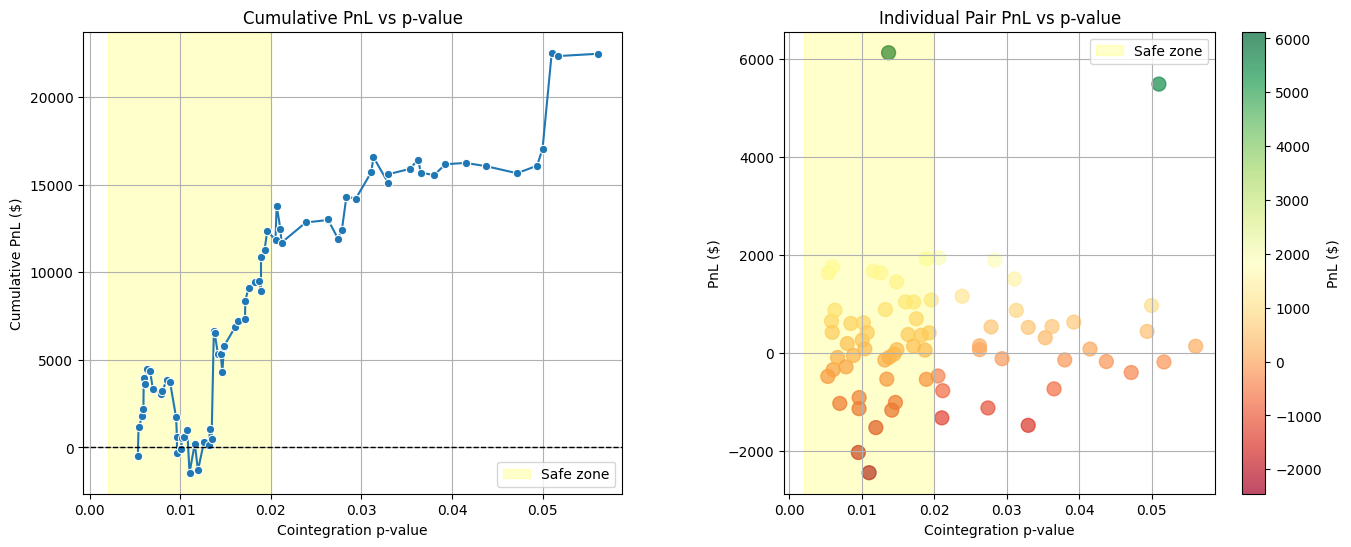

Distribution of total PnL by bin:
-inf to -2000: 2 pairs
-2000 to -1500: 1 pairs
-1500 to -1000: 7 pairs
-1000 to -500: 5 pairs
-500 to 0: 14 pairs
0 to 500: 17 pairs
500 to 1000: 12 pairs
1000 to 1500: 5 pairs
1500 to 2000: 8 pairs
2000 to 2500: 0 pairs
2500 to 3000: 0 pairs
3000 to 3500: 0 pairs
3500 to 4000: 0 pairs
4000 to 4500: 0 pairs
4500 to 5000: 0 pairs
5000 to 5500: 1 pairs
5500 to 6000: 0 pairs


In [167]:
# ==========================
# Annex: PnL vs Cointegration Strength
# ==========================
# This section explores how the quality of cointegration (p-value) relates to strategy performance (PnL).
# We visualize cumulative and individual PnL to highlight potential "safe zones" for pair selection.

import matplotlib.gridspec as gridspec

# Sort by cointegration p-value
df_sorted = all_metrics_df.sort_values('p_value')
cumulative_pnl_list = df_sorted['total_pnl'].cumsum()

# Define PnL bins for distribution analysis
bins = [-np.inf, -2000] + list(range(-1500, 6001, 500))
labels = [f"{bins[i]} to {bins[i+1]}" for i in range(len(bins)-1)]
all_metrics_df['PnL_bin'] = pd.cut(
    all_metrics_df['total_pnl'],
    bins=bins,
    labels=labels,
    right=False
)
bin_counts = all_metrics_df['PnL_bin'].value_counts().sort_index()

# --------------------------
# Create combined figure
# --------------------------
fig = plt.figure(figsize=(16,6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1], wspace=0.3)

# Left plot: cumulative PnL vs p-value
ax0 = plt.subplot(gs[0])
sns.lineplot(x=df_sorted['p_value'], y=cumulative_pnl_list, marker='o', ax=ax0)
ax0.set_xlabel('Cointegration p-value')
ax0.set_ylabel('Cumulative PnL ($)')
ax0.set_title('Cumulative PnL vs p-value')
ax0.axhline(0, color='black', linestyle='--', linewidth=1)
ax0.grid(True)
# Highlight "safe" p-value zone (low p-values = stronger cointegration)
ax0.axvspan(0.002, 0.02, color='yellow', alpha=0.2, label='Safe zone')
ax0.legend()

# Right plot: scatter of individual PnL vs p-value
ax1 = plt.subplot(gs[1])
sc = ax1.scatter(df_sorted['p_value'], df_sorted['total_pnl'],
                 c=df_sorted['total_pnl'], cmap='RdYlGn', s=100, alpha=0.7)
plt.colorbar(sc, ax=ax1, label='PnL ($)')
ax1.set_xlabel('Cointegration p-value')
ax1.set_ylabel('PnL ($)')
ax1.set_title('Individual Pair PnL vs p-value')
ax1.axvspan(0.002, 0.02, color='yellow', alpha=0.2, label='Safe zone')
ax1.grid(True)
ax1.legend()

plt.show()

# --------------------------
# Optional: print distribution of PnL bins
# --------------------------
print("Distribution of total PnL by bin:")
for bin_label, count in bin_counts.items():
    print(f"{bin_label}: {count} pairs")
